# Part II - Inference in Pyro

In [793]:
%reset -sf

In [794]:
from collections import defaultdict

import math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import pyro
from pyro.contrib.autoguide import *
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, JitTrace_ELBO
import pyro.optim as optim
import pyro.poutine as poutine
import seaborn as sns
import torch
from torch.distributions import constraints

%matplotlib inline

plt.rcParams["figure.figsize"] = (12, 6)

print('pyro ver: {}'.format(pyro.__version__))
print('pytorch ver: {}'.format(torch.__version__))

plt.rcParams.update({'font.size': 16,
                     'xtick.labelsize': 14,
                     'ytick.labelsize': 14,
                     'axes.titlesize': 'large', 
                     'axes.labelsize': 'medium'})

pyro ver: 0.4.0
pytorch ver: 1.2.0


## Dataset

Weekly unemployment insurance claim dataset that is provided by the Department of Labor (https://oui.doleta.gov/unemploy/claims.asp).

In [795]:
unemployment = pd.read_csv('data/unemployment_claims.csv')
unemployment['date'] = pd.to_datetime(unemployment['date'])
unemployment.head()

,date,initial claim
0,2010-01-02,651215
1,2010-01-09,825891
2,2010-01-16,659173
3,2010-01-23,507651
4,2010-01-30,538617


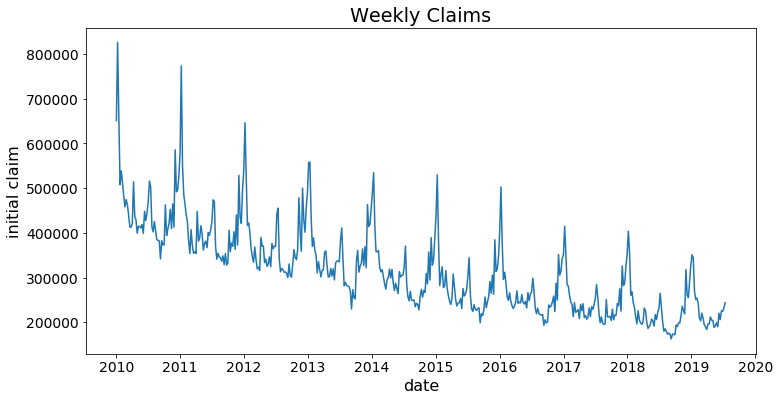

In [796]:
y = torch.tensor(unemployment['initial claim'].values, dtype=torch.float32)
sns.lineplot(x='date', y='initial claim', data=unemployment).set_title('Weekly Claims');

## Model specification in Pyro

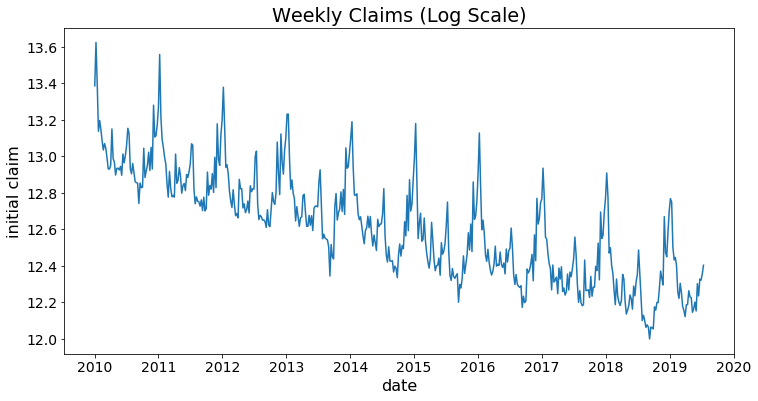

In [797]:
init_date = '2010-01-02'
time_range = pd.date_range(start=init_date, freq='7D', periods=len(y))
y_log = y.log()
fig, ax = plt.subplots()
ax.plot(time_range, y_log)
ax.set(title='Weekly Claims (Log Scale)', xlabel='date', ylabel='initial claim');

### Fitting a Regression Model

The data can be modeled as a Generalized Linear Model with a log link.

In [798]:
def model_global_trend(y):
    slope = pyro.param('slope', torch.tensor(1.))
    intercept = pyro.param('intercept', torch.tensor(13.))
    for i in range(len(y)):
        log_y_hat = slope * i + intercept
        pyro.sample('y_{}'.format(i), dist.LogNormal(log_y_hat, 1.), obs=log_y[i])

**Vectorized model:** We can vectorize the model by using `pyro.plate`.

In [799]:
def model_global_trend(y):
    slope = pyro.param('slope', torch.tensor(1.))
    intercept = pyro.param('intercept', torch.tensor(13.))
    with pyro.plate('N', len(y)) as t:
        log_y_hat = slope * t.type(torch.float) + intercept
        pyro.sample('y', dist.LogNormal(log_y_hat, 1.), obs=y)

**Test-Train Split**: Reserve the last 100 data-points for testing.

In [800]:
N = len(y)
N_test = 100
N_train = N - N_test
y_train = y[:-N_test]

In [801]:
%%time

opt = optim.Adam({'lr': 0.08})
pyro.clear_param_store()
pyro.set_rng_seed(1)
svi = SVI(model_global_trend, lambda x: None, opt, loss=Trace_ELBO())

for i in range(1600):
    loss = svi.step(y_train)
    if i % 100 == 0:
        print('ELBO loss: {}'.format(loss / len(y_train)))
print('ELBO loss: {}'.format(loss / len(y_train)))

ELBO loss: 26399.26381909548
ELBO loss: 14.252707629946608
ELBO loss: 13.745012906328517
ELBO loss: 13.729082423837939
ELBO loss: 13.712590049858669
ELBO loss: 13.696713548209798
ELBO loss: 13.682234414258794
ELBO loss: 13.669615165672111
ELBO loss: 13.659033693859925
ELBO loss: 13.65048509147299
ELBO loss: 13.643809869660805
ELBO loss: 13.638776156171483
ELBO loss: 13.635107912609925
ELBO loss: 13.632519285882537
ELBO loss: 13.630751413316583
ELBO loss: 13.629593278894472
ELBO loss: 13.628859630182161
CPU times: user 1.1 s, sys: 24.2 ms, total: 1.12 s
Wall time: 1.13 s


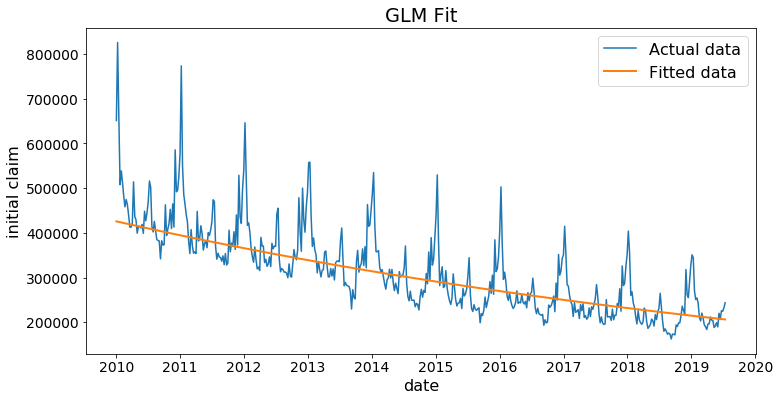

In [802]:
slope = pyro.param('slope')
intercept = pyro.param('intercept')
model_fit = (slope * torch.arange(len(y)).type(torch.float) + intercept).exp()

fig, ax = plt.subplots()
ax.plot(time_range, y, label='Actual data')
ax.plot(time_range, model_fit.detach(), linewidth=2, label='Fitted data')
ax.set(title='GLM Fit', xlabel='date', ylabel='initial claim')
plt.legend();

### Fitting a Seasonal Component + Global Trend

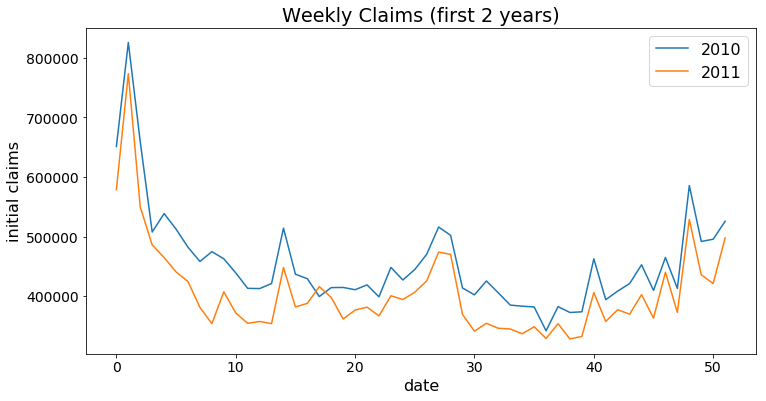

In [803]:
fig, ax = plt.subplots()
ax.plot(np.arange(52), y[:52], label='2010');
ax.plot(np.arange(52), y[52:104], label='2011');
plt.legend()
ax.set(title='Weekly Claims (first 2 years)', xlabel='date', ylabel='initial claims');

In [804]:
def model_sgt(y):    
    slope = pyro.param('slope', torch.tensor(1.))
    intercept = pyro.param('intercept', torch.tensor(13.))
    seasonality = pyro.param('seasonality', torch.ones(52))
    seasonality = seasonality - seasonality.mean()
    N = len(y)
    with pyro.plate('N', N) as t:
        seasonality_factor = seasonality.repeat(math.ceil(N / 52))[:N]
        log_y_hat = slope * t.type(torch.float) + intercept + seasonality_factor
        pyro.sample('y', dist.LogNormal(log_y_hat, 1.), obs=y)

In [805]:
%%time

opt = optim.Adam({'lr': 0.08})
pyro.clear_param_store()
pyro.set_rng_seed(1)
svi = SVI(model_sgt, lambda x: None, opt, loss=Trace_ELBO())

for i in range(3000):
    loss = svi.step(y_train)
    if i % 500 == 0:
        print('ELBO loss: {}'.format(loss / len(y_train)))
print('ELBO loss: {}'.format(loss / len(y_train)))        

ELBO loss: 26399.26381909548
ELBO loss: 13.683770414572864
ELBO loss: 13.631697304883794
ELBO loss: 13.61758131477701
ELBO loss: 13.615883371937814
ELBO loss: 13.615797493326005
ELBO loss: 13.615795039651381
CPU times: user 2.81 s, sys: 47.6 ms, total: 2.86 s
Wall time: 2.87 s


In [806]:
print('slope', pyro.param('slope').detach())

slope tensor(-0.0018)


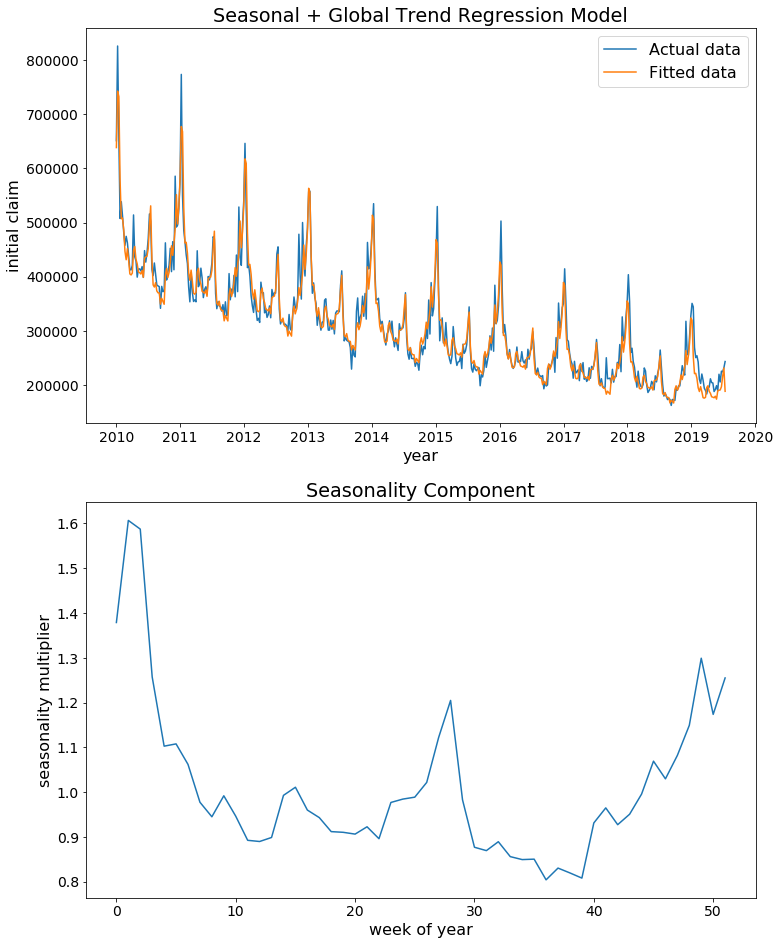

In [807]:
slope = pyro.param('slope').detach()
intercept = pyro.param('intercept').detach()
seasonality = pyro.param('seasonality').detach()
seasonality = (seasonality - seasonality.mean())
seasonality_rep = seasonality.repeat(math.ceil(len(y) / 52))[:len(y)]
model_fit = (slope * torch.arange(len(y)).type(torch.float) + intercept + seasonality_rep).exp()

fig, ax = plt.subplots(2, 1, figsize=(12, 16))
ax[0].plot(time_range, y, label='Actual data')
ax[0].plot(time_range, model_fit.detach(), label='Fitted data')
ax[0].set(title='Seasonal + Global Trend Regression Model', 
          xlabel='year', 
          ylabel='initial claim')
ax[0].legend();
ax[1].plot(range(52), seasonality.exp())
ax[1].set(title='Seasonality Component', 
          xlabel='week of year', 
          ylabel='seasonality multiplier');

## Time Series Forecasting

In [808]:
def prob_sgt(N, x, y):
    slope = pyro.sample('slope', dist.Normal(0, 1e-2))
    obs_sd = pyro.sample('obs_sd', dist.HalfNormal(1e-2))
    seasonality = pyro.param('seasonality', torch.ones(52))
    seasonality = seasonality - seasonality.mean()
    with pyro.plate('N', N) as t:
        seasonality_factor = seasonality.roll(-(x + 1) % 52).repeat(math.ceil(N / 52))[:N]
        y_intercept = y.log() - seasonality[x % 52]
        log_y_hat = slope * (t + 1).type(torch.float) + y_intercept + seasonality_factor
        pyro.sample('y', dist.LogNormal(log_y_hat, obs_sd))

### Doing Predictions

The model remains the same for both inference and prediction.

In [809]:
def get_predictive_quantiles(model, *args, 
                             guide=None, 
                             num_samples=500, 
                             quantiles=[0.1, 0.5, 0.9]):    
    preds = []
    if not guide:
        guide = model
    for i in range(num_samples):
        guide_trace = poutine.trace(guide).get_trace(*args)
        replay_model = poutine.replay(model, guide_trace)
        model_trace = poutine.trace(replay_model).get_trace(*args)
        preds.append(model_trace.nodes['y']['value'].detach())
    preds = torch.stack(preds)
    return [preds.kthvalue(int(q * num_samples), dim=0)[0] for q in quantiles]

### Are the Priors Reasonable?

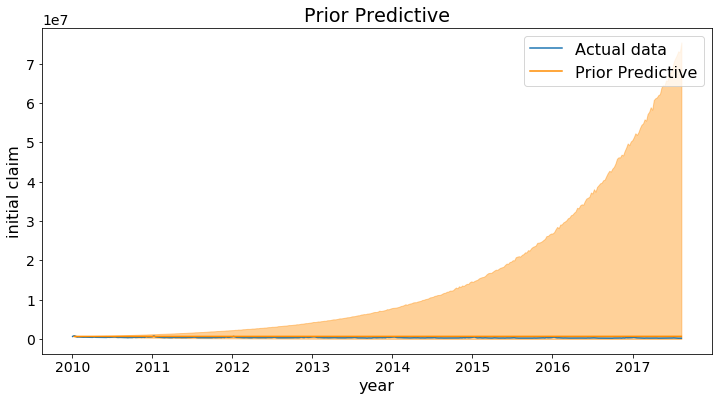

In [810]:
pyro.clear_param_store()
pred_p10, pred_p50, pred_p90 = get_predictive_quantiles(prob_sgt, N_train-1, 1, y_train[0])
plt.plot(time_range[:N_train], y_train, label='Actual data')
plt.plot(time_range[1:N_train], pred_p50, label='Prior Predictive', color='darkorange')
plt.fill_between(time_range[1:N_train], pred_p10, pred_p90, alpha=0.4, 
                 color='darkorange')
plt.title('Prior Predictive')
plt.xlabel('year')
plt.ylabel('initial claim')
plt.legend();

### MAP Inference Using a Delta Autoguide

In [811]:
%%time

opt = optim.Adam({'lr': 0.1})
pyro.clear_param_store()
pyro.set_rng_seed(1)

model = poutine.condition(prob_sgt, {'y': y_train[1:]})
guide_delta = AutoDelta(model)
guide_delta(N_train-1, x=0, y=y_train[0])
svi = SVI(model, guide_delta, opt, loss=Trace_ELBO())
#pyro.param('auto_scale').fill_(-10.)

for i in range(5000):
    loss = svi.step(N_train-1, x=0, y=y_train[0])
    if i % 500 == 0:
        print('ELBO loss: {}'.format(loss / len(y_train)))
print('ELBO loss: {}'.format(loss / len(y_train)))

ELBO loss: 823.8358951465568
ELBO loss: 12.598687963869104
ELBO loss: 11.466281306204484
ELBO loss: 11.441825945772717
ELBO loss: 11.441274714829335
ELBO loss: 11.44062346789106
ELBO loss: 11.439783592319968
ELBO loss: 11.438695013822622
ELBO loss: 11.437316837023252
ELBO loss: 11.435554077876873
ELBO loss: 11.433349695636998
CPU times: user 8.69 s, sys: 78.3 ms, total: 8.77 s
Wall time: 8.78 s


In [812]:
pyro.get_param_store().get_state()

{'params': {'seasonality': tensor([1.1771, 1.3114, 1.2993, 1.0662, 0.9350, 0.9396, 0.8975, 0.8146, 0.7808,
          0.8292, 0.7821, 0.7236, 0.7206, 0.7307, 0.8302, 0.8483, 0.7966, 0.7789,
          0.7452, 0.7435, 0.7391, 0.7569, 0.7277, 0.8142, 0.8218, 0.8262, 0.8590,
          0.9527, 1.0237, 0.8201, 0.7062, 0.6976, 0.7202, 0.6821, 0.6742, 0.6753,
          0.6195, 0.6516, 0.6385, 0.6244, 0.7661, 0.8016, 0.7620, 0.7869, 0.8330,
          0.9043, 0.8667, 0.9163, 0.9764, 1.0990, 0.9975, 1.0645],
         requires_grad=True),
  'auto_slope': tensor(-0.0018, requires_grad=True),
  'auto_obs_sd': tensor(-3.0953, requires_grad=True)},
 'constraints': {'seasonality': Real(),
  'auto_slope': Real(),
  'auto_obs_sd': GreaterThan(lower_bound=0.0)}}

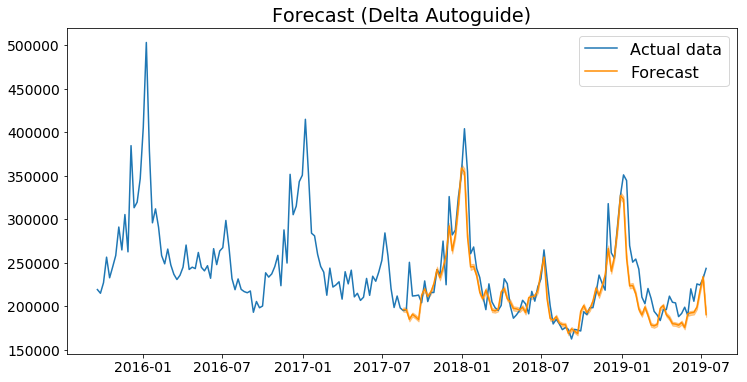

In [817]:
pred_p10, pred_p50, pred_p90 = get_predictive_quantiles(prob_sgt, N_test, N_train-1, y[N_train-1], 
                                                        guide=guide_delta)
plt.plot(time_range[-200:], y[-200:], label='Actual data')
plt.plot(time_range[N_train:N_train+N_test], pred_p50, label='Forecast',
         color='darkorange')
plt.fill_between(time_range[398:len(y)], pred_p10, pred_p90, alpha=0.4, 
                 color='darkorange')
plt.title('Forecast (Delta Autoguide)')
plt.legend();

In [818]:
%%time

opt = optim.Adam({'lr': 0.1})
pyro.clear_param_store()
pyro.set_rng_seed(1)

model = poutine.condition(prob_sgt, {'y': y_train[1:]})
guide_diagnormal = AutoDiagonalNormal(model)

# Initialize using MAP estimate
pyro.param('auto_loc', torch.tensor([-1e-3, -3]))
pyro.param('auto_scale', torch.tensor([1e-2, 1e-2]), 
           constraint=constraints.positive)
svi = SVI(model, guide_diagnormal, opt, loss=Trace_ELBO())

for i in range(8000):
    loss = svi.step(N_train-1, x=0, y=y_train[0])
    if i % 500 == 0:
        print('ELBO loss: {}'.format(loss / len(y_train)))
print('ELBO loss: {}'.format(loss / len(y_train)))

ELBO loss: 538.890070006476
ELBO loss: 14.271812132555036
ELBO loss: 16.802912433542797
ELBO loss: 13.013138870797565
ELBO loss: 12.928246283950518
ELBO loss: 12.968906822815612
ELBO loss: 12.77439558835485
ELBO loss: 12.788116074686673
ELBO loss: 12.78089598644918
ELBO loss: 12.772565627217892
ELBO loss: 12.525034188625202
ELBO loss: 12.951698146573262
ELBO loss: 13.223484874370708
ELBO loss: 13.105155680047806
ELBO loss: 12.922066800558387
ELBO loss: 13.14855785226103
ELBO loss: 13.788403948347772
CPU times: user 18.2 s, sys: 134 ms, total: 18.4 s
Wall time: 18.4 s


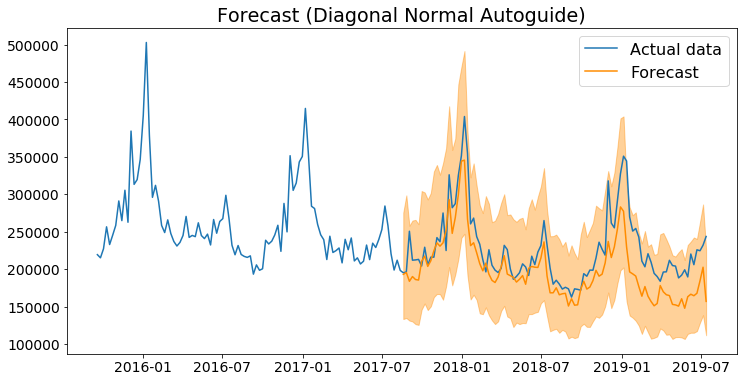

In [819]:
pred_p10, pred_p50, pred_p90 = get_predictive_quantiles(prob_sgt, N_test, N_train-1, y[N_train-1], 
                                                        guide=guide_diagnormal)
plt.plot(time_range[-200:], y[-200:], label='Actual data')
plt.plot(time_range[N_train:N_train+N_test], pred_p50, label='Forecast',
         color='darkorange')
plt.fill_between(time_range[398:len(y)], pred_p10, pred_p90, alpha=0.4, 
                 color='darkorange')
plt.title('Forecast (Diagonal Normal Autoguide)')
plt.legend();

In [820]:
pyro.get_param_store().get_state()

{'params': {'auto_loc': tensor([-0.0034, -1.2748], requires_grad=True),
  'auto_scale': tensor([-8.8938, -4.8108], requires_grad=True),
  'seasonality': tensor([1.1751, 1.3061, 1.2940, 1.0609, 0.9297, 0.9343, 0.8922, 0.8093, 0.7755,
          0.8239, 0.7768, 0.7183, 0.7153, 0.7254, 0.8249, 0.8430, 0.7913, 0.7736,
          0.7399, 0.7382, 0.7338, 0.7516, 0.7223, 0.8088, 0.8165, 0.8209, 0.8536,
          0.9474, 1.0184, 0.8148, 0.7009, 0.6923, 0.7149, 0.6768, 0.6689, 0.6700,
          0.6142, 0.6463, 0.6332, 0.6191, 0.7608, 0.7963, 0.7567, 0.7816, 0.8277,
          0.8990, 0.8614, 0.9110, 0.9711, 1.0937, 0.9922, 1.0592],
         requires_grad=True)},
 'constraints': {'auto_loc': Real(),
  'auto_scale': GreaterThan(lower_bound=0.0),
  'seasonality': Real()}}

## Forecast Using MCMC

In [832]:
from pyro.infer.mcmc import NUTS
from pyro.infer.mcmc.api import MCMC
from pyro.infer.mcmc.util import predictive
from pyro.ops.stats import hpdi

In [833]:
def prob_sgt_mcmc(N, x, y, seasonality):
    slope = pyro.sample('slope', dist.Normal(0, 1.))
    obs_sd = pyro.sample('obs_sd', dist.HalfNormal(1.))
    seasonality = seasonality - seasonality.mean()

    with pyro.plate('N', N) as t:
        seasonality_factor = seasonality.roll(-(x + 1) % 52).repeat(math.ceil(N / 52))[:N]
        y_intercept = y.log() - seasonality[x % 52]
        log_y_hat = slope * (t + 1).type(torch.float) + y_intercept + seasonality_factor
        pyro.sample('y', dist.LogNormal(log_y_hat, obs_sd))

In [834]:
seasonality = pyro.param('seasonality').detach()
model = poutine.condition(prob_sgt_mcmc, {'y': y_train[1:]})
nuts_kernel = NUTS(model, jit_compile=True, max_tree_depth=5, ignore_jit_warnings=True)
mcmc = MCMC(nuts_kernel, num_samples=800)
mcmc.run(N_train-1, 0, y_train[0], seasonality)

sample: 100%|██████████| 1600/1600 [00:16<00:00, 98.26it/s, step size=3.95e-03, acc. prob=0.943] 


In [836]:
print(mcmc.diagnostics()['divergences'])

{'chain 0': []}


In [837]:
mcmc.summary()



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     slope     -0.00      0.00     -0.00     -0.00     -0.00    639.27      1.00
    obs_sd      0.06      0.00      0.06      0.06      0.06     82.11      1.00




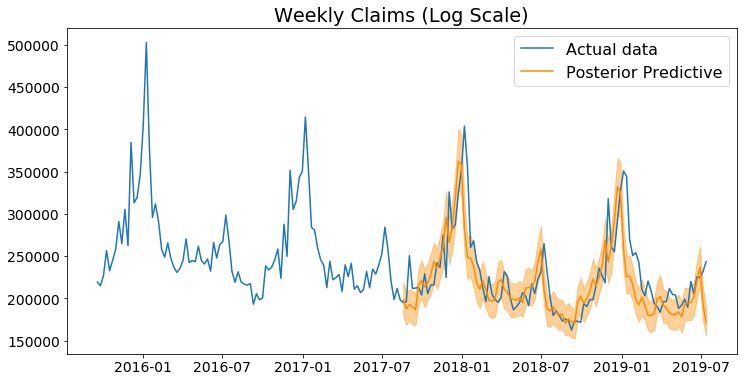

In [838]:
from pyro.util import ignore_experimental_warning

with ignore_experimental_warning():
    samples = predictive(prob_sgt_mcmc, mcmc.get_samples(), N_test, N_train, y_train[-1], 
                         seasonality=pyro.param('seasonality').detach())
pred_p10, pred_p90 = hpdi(samples['y'], prob=0.9)
pred_p50 = samples['y'].median(dim=0)[0]
plt.plot(time_range[-200:], y[-200:], label='Actual data')
plt.plot(time_range[N_train:N_train+N_test], pred_p50, label='Posterior Predictive',
         color='darkorange')
plt.fill_between(time_range[N_train:N_train+N_test], pred_p10, pred_p90, alpha=0.4, 
                 color='darkorange')
plt.title('Weekly Claims (Log Scale)')
plt.legend();